n_samples          2.200000e+01
region_len_bp      9.999942e+07
S_total            8.874830e+05
pi_bp_mean         2.344762e-03
thetaW_bp_mean     2.038196e-03
R_pi_over_theta    1.150411e+00
D_median           5.643281e-01
D_mean             5.606541e-01
D_sd               1.061996e-01
frac_D_pos         1.000000e+00
frac_D_lt_-1.5     0.000000e+00
singleton_pct      1.448219e-01
doubleton_pct      9.535394e-02


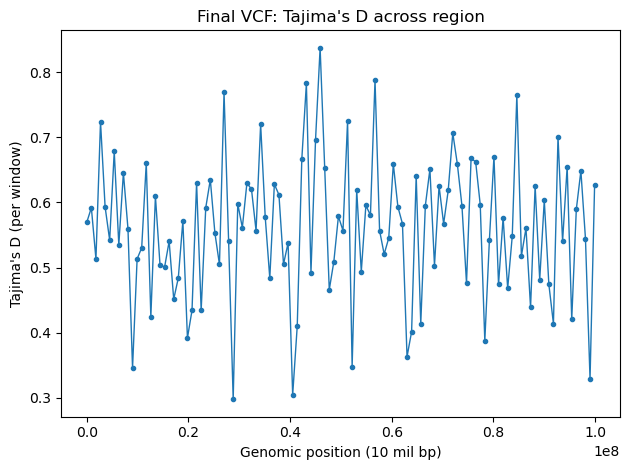

In [2]:
#!/usr/bin/env python3
import gzip, sys, math
import numpy as np
import pandas as pd

WIN_BP = 900000  # try 5kb; later repeat with 2.5kb, 10kb to see trade-offs

def harmonic(n):
    return sum(1.0/i for i in range(1, n)) if n>1 else 0.0

def tajima_D(S, pi_sum, n_hap):
    if S <= 0 or n_hap < 2: return float('nan')
    a1 = harmonic(n_hap)
    a2 = sum(1.0/(i*i) for i in range(1, n_hap))
    b1 = (n_hap + 1.0)/(3.0*(n_hap-1.0))
    b2 = 2.0*(n_hap*n_hap + n_hap + 3.0)/(9.0*n_hap*(n_hap-1.0))
    c1 = b1 - 1.0/a1
    c2 = b2 - (n_hap + 2.0)/(a1*n_hap) + a2/(a1*a1)
    e1 = c1/a1
    e2 = c2/(a1*a1 + a2)
    thetaW = S/a1
    var = e1*S + e2*S*(S-1.0)
    return (pi_sum - thetaW)/math.sqrt(var) if var>0 else float('nan')

def main(tsv_gz):
    # Load POS + GT strings
    with gzip.open(tsv_gz, 'rt') as f:
        header = f.readline().strip().split('\t')
    n_samples = len(header) - 2
    df = pd.read_csv(tsv_gz, sep='\t', header=None, skiprows=1,
                     names=['CHROM','POS'] + [f's{i}' for i in range(n_samples)],
                     dtype={0:str,1:int})
    pos = df['POS'].to_numpy(dtype=np.int64)
    # Convert GT to diploid dosages 0/1/2 (no missing due to F_MISSING==0)
    GT = df.drop(columns=['CHROM','POS']).to_numpy(str)
    GT = np.char.replace(GT, '|', '/')
    d = np.char.count(GT, '1')   # counts of '1' in e.g. "0/1","1/1" → 1 or 2
    D = d.astype(np.int16)       # sites x samples, values {0,1,2}
    n_hap = 2 * n_samples

    # Windowing
    L = pos.max() - pos.min() + 1
    nwin = int(math.ceil(L/float(WIN_BP)))
    win_starts = [pos.min() + i*WIN_BP for i in range(nwin)]
    win_lens = np.array([WIN_BP]*(nwin-1) + [L - WIN_BP*(nwin-1)], dtype=float)

    # Per-site allele freq using hap count (2 per sample)
    # (no missing after filter → constant n_hap)
    k = D.sum(axis=1)                   # alt count (0..2n)
    p = k.astype(np.float64) / n_hap
    pi_site = 2.0*p*(1.0-p)             # contribution to π per site (haploid form)

    # Folded MAC for SFS slices
    mac = np.minimum(k, n_hap - k)

    # Assign sites to windows
    widx = np.clip(((pos - pos.min()) // WIN_BP).astype(int), 0, nwin-1)

    S = np.bincount(widx, minlength=nwin)
    pi_sum = np.bincount(widx, weights=pi_site, minlength=nwin)
    sing = np.bincount(widx, weights=(mac==1), minlength=nwin)
    doub = np.bincount(widx, weights=(mac==2), minlength=nwin)

    a1 = harmonic(n_hap)
    thetaW = np.zeros(nwin)
    thetaW[S>0] = S[S>0] / a1
    Dwin = np.array([tajima_D(int(S[i]), float(pi_sum[i]), n_hap) for i in range(nwin)])
    pi_bp = np.divide(pi_sum, win_lens, out=np.zeros_like(pi_sum), where=win_lens>0)
    thetaW_bp = np.divide(thetaW, win_lens, out=np.zeros_like(thetaW), where=win_lens>0)

    # Global summaries (features)
    valid = ~np.isnan(Dwin)
    out = {
        "n_samples": n_samples,
        "region_len_bp": int(L),
        "S_total": int(S.sum()),
        "pi_bp_mean": float(np.nanmean(pi_bp)),
        "thetaW_bp_mean": float(np.nanmean(thetaW_bp)),
        "R_pi_over_theta": float(np.nanmean(pi_bp)/np.nanmean(thetaW_bp)) if np.nanmean(thetaW_bp)>0 else float('nan'),
        "D_median": float(np.nanmedian(Dwin)),
        "D_mean": float(np.nanmean(Dwin)),
        "D_sd": float(np.nanstd(Dwin)),
        "frac_D_pos": float(np.mean(Dwin[valid] > 0.0)) if np.any(valid) else float('nan'),
        "frac_D_lt_-1.5": float(np.mean(Dwin[valid] < -1.5)) if np.any(valid) else float('nan'),
        "singleton_pct": float(np.sum(sing)/np.sum(S)) if np.sum(S)>0 else float('nan'),
        "doubleton_pct": float(np.sum(doub)/np.sum(S)) if np.sum(S)>0 else float('nan')
    }
    print(pd.Series(out).to_string(index=True))

    # compute Dwin, win_starts above
    try:
        import matplotlib.pyplot as plt
        plt.figure()
        x = np.array(win_starts)
        plt.plot(x, Dwin, marker='.', linewidth=1)
        plt.xlabel("Genomic position (10 mil bp)")
        plt.ylabel("Tajima's D (per window)")
        plt.title("Final VCF: Tajima's D across region")
        plt.tight_layout()
        plt.savefig("final_tajimasD.png", dpi=150)
        # in Jupyter, also show it:
        plt.show()
    except Exception as e:
        print(f"[plotting skipped] {e}")

if __name__ == "__main__":
    main("final.GT.tsv.gz")